In [1]:
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

import astropy
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.wcs import WCS
from astropy.io import fits

from transitleastsquares import catalog_info

import time

from lightkurve import search_targetpixelfile

from lightkurve import TessTargetPixelFile

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


1
TESS Sector 01
number of files:  6
 
0 TIC 25155310
s 1


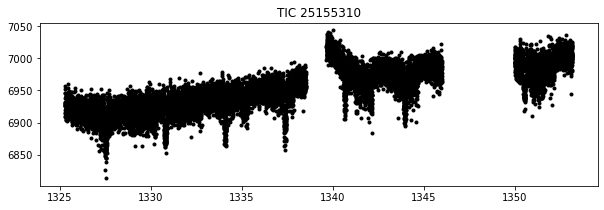

 
1 TIC 29344935
s 1


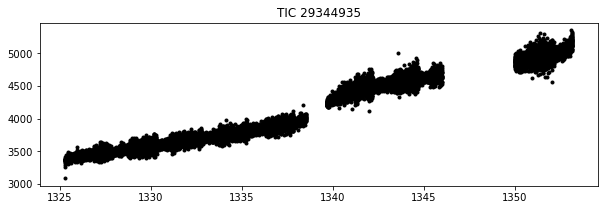

 
2 TIC 52368076
s 1


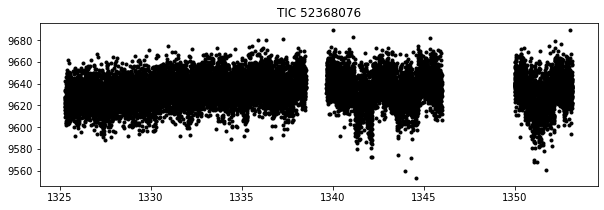

 
3 TIC 55650590
s 1


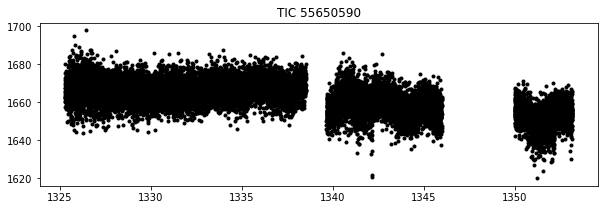

 
4 TIC 62483237
s 1


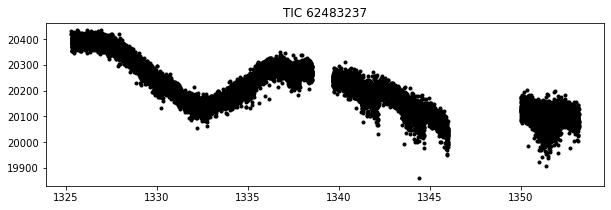

 
5 TIC 231702397
s 1


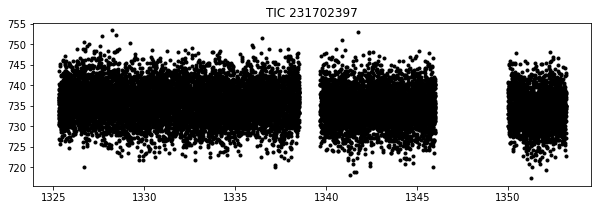

 
runtime:  0.0745315670967102  minutes


In [32]:
# TOIs of interest
TOI_IDs_Sector1 = [25155310, 29344935, 55650590, 52368076, 62483237, 231702397 ]
TOI_IDs_Sector2 = [55650590, 52368076]
TOI_IDs_Sector3 = [92226327,55650590]

z=TOI_IDs_Sector1




#Finding Light Curves
#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.



#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
path = '/Users/felizd/Desktop/TESS/9_wotan_pipeline/TOIs/TPF_processed/S'+str(SectorNum)+'/'
savepath='/Users/felizd/Desktop/TESS/9_wotan_pipeline/TOIs/TPF_processed/S'+str(SectorNum)+'/'


start=time.time()

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.fits')] #finds every file (*) that ends with .lc

data.sort(key=lambda x: int(os.path.basename(x).split('_')[4][:-4])) #sorts them in alphanumeric order based on TIC ID (smallest first)

print ("number of files: ",len(data)) #number of files)
print (" ")

#Lets verify that there are or are not values for R, M on MAST

for ii in range(len(data)): #creating a for loop to show light curve figures for all files
    
    fits_file=data[ii]
    ID = int((os.path.basename(data[ii]).split)('_')[4][:-4])
    

    print(ii,"TIC", ID)
    tpf=TessTargetPixelFile(fits_file)

    # Create a median image of the source over time
    median_image = np.nanmedian(tpf.flux, axis=0)

    # Select pixels which are brighter than the 95th percentile of the median image
    aperture_mask = median_image > np.nanpercentile(median_image, 95)



    lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
    #excluding bad data points
    m=np.where(tpf.quality==0)[0] 
    t=lc.time[m]
    flux=lc.flux[m]
    flux_err = lc.flux_err[m]
    
    #known bad data points with high telescope jitter:
    print("s",SectorNum)
    if SectorNum==1:
        jittermask = (t < 1346) | (t > 1350)
        t=t[jittermask]
        flux=flux[jittermask]
        flux_err=flux_err[jittermask]
        
    if SectorNum==3:
        jittermask = (t < 1382.6) | (t > 1383.65)
        t=t[jittermask]
        flux=flux[jittermask]
        flux_err=flux_err[jittermask]
        

    #excluding any NaN values in flux values
    t = t[~np.isnan(flux)]
    flux=flux[~np.isnan(flux)]
    flux_err=flux_err[~np.isnan(flux)]
    
    plt.figure(figsize=(10,3))
    plt.title("TIC "+str(ID))
    plt.plot(t,flux,color='black',marker='.',linestyle='none')
    plt.show()
    
    #save data
    np.savetxt(savepath+"TIC_"+str(ID)+"_TPF_lc.txt",list(zip(t,flux,flux_err)))


    print (" ")
end=time.time()

print('runtime: ', (end-start)/(60), " minutes")